In [1]:
import sys
sys.path.append("..")

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import distributions as dist
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

from torchvision.datasets import MNIST, FashionMNIST
from torchvision import transforms as tr
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from pprint import pprint
from inpainting.custom_layers import Reshape
from inpainting.losses import nll_batch_loss
from inpainting.inpainters.digits import DigitsLinearInpainter

In [3]:
torch.cuda.is_available()

False

In [43]:
digits = datasets.load_digits()
X = digits['data']
y = digits['target']

J = []
for i in range(X.shape[0]):
    mask = np.ones((8,8))
    m_height = 3
    m_width = 3
    m_x = np.random.randint(0, 8 - m_width)
    m_y = np.random.randint(0, 8 - m_height)

    mask[m_y:m_y+m_height, m_x:m_x+m_width] = 0
    J.append(mask.reshape(-1))
    
J = np.vstack(J)
    
X = X / 16
X.shape, J.shape, y.shape, set(y)


((1797, 64), (1797, 64), (1797,), {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

In [44]:
X_train, X_test, J_train, J_test, y_train, y_test = train_test_split(X, J, y, test_size=0.33, random_state=42)

In [45]:
def vis_digit_mask(x, j, ax= None):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    
    x_j = x *j
    vis = np.vstack([x_j, x_j, x_j + (j==0)]).T.reshape(8,8,3) 
    
    ax.imshow(vis)
    ax.axis("off")

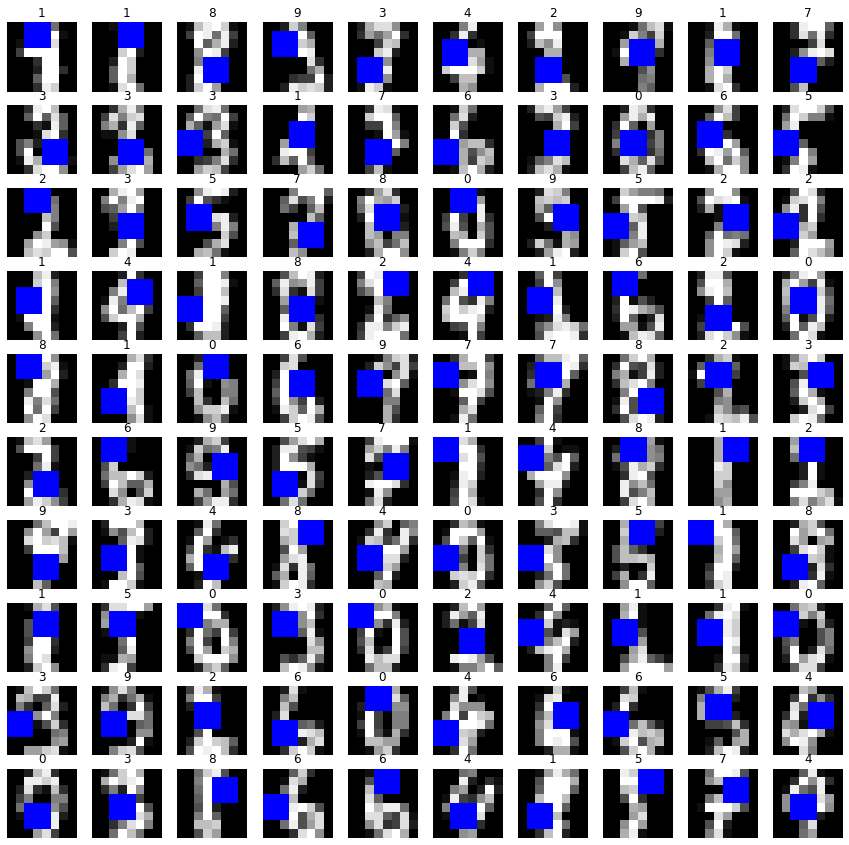

In [46]:
fig, axes = plt.subplots(10, 10, figsize=(15, 15))
for i in range(100):
    ax = axes[i // 10, i%10]
    ax.set_title(f"{y_train[i]}")
    vis_digit_mask(X_train[i], J_train[i],ax)

In [47]:
ds_train = TensorDataset(
    torch.Tensor(X_train), 
    torch.Tensor(J_train),
    torch.Tensor(y_train).long()
)

ds_test = TensorDataset(
    torch.Tensor(X_test), 
    torch.Tensor(J_test),
    torch.Tensor(y_test).long()
)

batch_size=16
dl_train = DataLoader(ds_train, batch_size, shuffle=True)
dl_test = DataLoader(ds_test, batch_size, shuffle=True)

In [48]:
def nll_loss(X, J, P, M, A, D) -> torch.autograd.Variable:
    zipped = zip(X, J, P, M, A, D)
    losses = []
    
    
    for i, (x, j, p, m, a, d) in enumerate(zipped):
        mask_inds = (j==0).nonzero().squeeze()
        x_masked = torch.index_select(x, 0, mask_inds)
        a_masked = torch.index_select(a, 2, mask_inds)
        m_masked, d_masked = [
            torch.index_select(t, 1, mask_inds)
            for t in [m, d]
        ]
        
        for (p_i, m_i, d_i, a_i) in zip(p, m_masked, d_masked, a_masked):
            if a_i.shape[1] > 0:
                cov = (a_i.T @ a_i) + torch.diag(d_i ** 2)
                mvn_d = dist.MultivariateNormal(m_i, cov) # calculate this manually
                l = - mvn_d.log_prob(x_masked) 
                losses.append(l)
            else:
                losses.append(torch.autograd.Variable(torch.tensor(0.0), requires_grad=True))
    return torch.stack(losses).mean()

  0%|          | 0/50 [00:00<?, ?it/s]/home/mprzewie/.anaconda3/envs/uj/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 50/50 [01:26<00:00,  1.73s/it]

tensor(0.0078, grad_fn=<MeanBackward0>) tensor(0.0212, grad_fn=<MeanBackward0>)


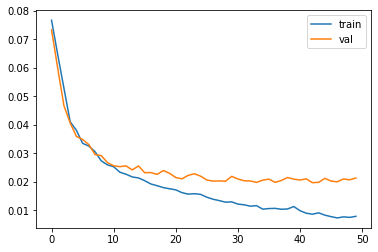

In [49]:
inpainter = DigitsLinearInpainter()
# inpainter = inpainter.cuda()
opt = optim.Adam(inpainter.parameters(), lr=4e-3)
n_epochs = 50
train_hist = []
val_hist = []
for e in tqdm(range(n_epochs)):
    inpainter.train()
    train_losses = [] 
    for i, (x, j, y) in enumerate(dl_train):
        inpainter.zero_grad()
#         x, j = x.cuda(), j.cuda()
        p, m, a, d = inpainter(x, j)
        loss = ((x - m[:, 0, :]) **2).mean()
#         loss = nll_loss(x, j, p, m, a, d)
        loss.backward()
        opt.step()
        train_losses.append(loss)
    train_hist.append(torch.stack(train_losses).mean())
    
    inpainter.eval()
    val_losses = []
    for i, (x, j, y) in enumerate(dl_test):
        inpainter.zero_grad()
#         x, j = x.cuda(), j.cuda()
        p, m, a, d = inpainter(x, j)
        loss = ((x - m[:, 0, :]) **2).mean()

#         loss = nll_loss(x, j, p, m, a, d)
        val_losses.append(loss)
    val_hist.append(torch.stack(val_losses).mean())

#     print(train_hist[-1], val_losses[-1])
plt.plot(list(range(n_epochs)), train_hist, label="train")
plt.plot(list(range(n_epochs)), val_hist, label="val")
plt.legend()
print(train_hist[-1], val_hist[-1])

In [50]:
classifier = MLPClassifier((100, 200, 10,), learning_rate_init=4e-3, max_iter=1000)
classifier.fit(X_train, y_train)
accuracy_score(classifier.predict(X_test), y_test)

0.9663299663299664

In [51]:
X_test_masked = X_test * J_test
y_test_masked_pred = classifier.predict(X_test_masked)

accuracy_score(y_test_masked_pred, y_test)


0.6683501683501684

In [52]:
P_test, M_test, A_test, D_test = inpainter(torch.Tensor(X_test_masked), torch.Tensor(J_test))

X_test_inpainted = X_test_masked.copy()
X_test_inpainted[J_test == 0] = M_test.detach().cpu().numpy()[:, 0][J_test == 0]

# print("X_test[0]", X_test[0]), 
# print("X_test_masked[0]", X_test_masked[0]) 
# print("M_test.detach().numpy()[0, 0]", M_test.detach().cpu().numpy()[0, 0]) 
# print("X_test_inpainted[0]", X_test_inpainted[0])
y_test_inp_pred = classifier.predict(X_test_inpainted)
accuracy_score(y_test_inp_pred, y_test)

/home/mprzewie/.anaconda3/envs/uj/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.9444444444444444

AttributeError: 'AxesSubplot' object has no attribute 'subplots'

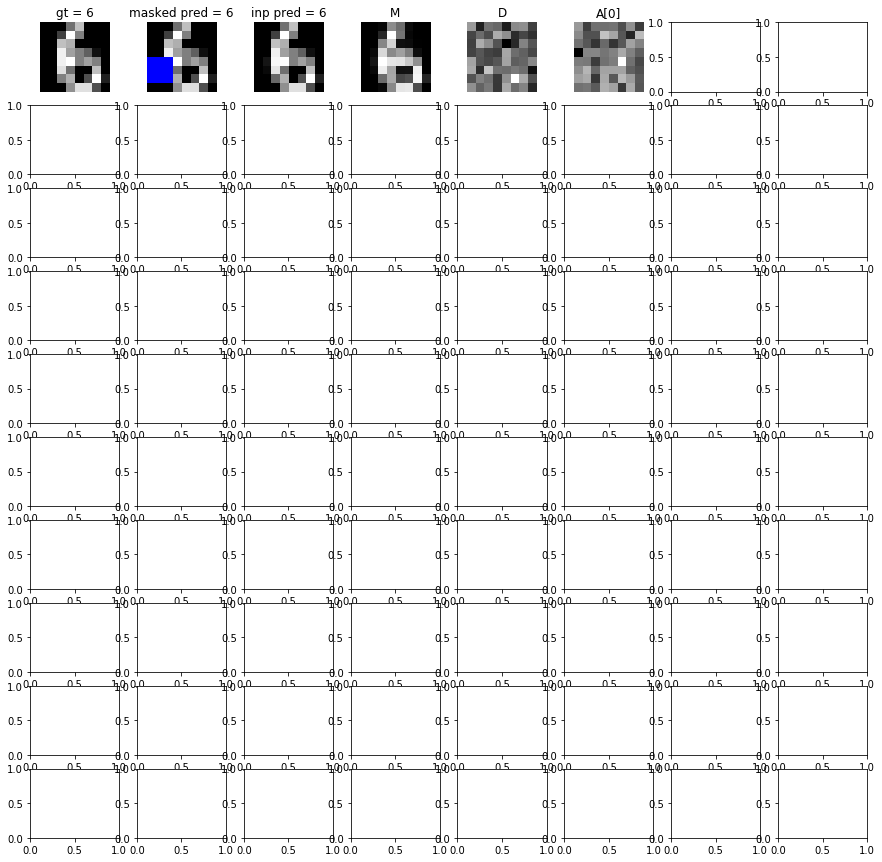

In [59]:
fig, axes = plt.subplots(10, 5 + A_test.shape[2], figsize=(15, 15))
for i in range(10):
    
    ax = axes[i, 0]
    ax.set_title(f"gt = {y_test[i]}")
    ax.imshow(X_test[i].reshape(8,8), cmap="gray")
    ax.axis("off")
    
    axes[i,1].set_title(f"masked pred = {y_test_masked_pred[i]}")
    vis_digit_mask(X_test[i], J_test[i], ax=axes[i, 1])
    
    ax = axes[i, 2]
    ax.set_title(f"inp pred = {y_test_inp_pred[i]}")
    ax.imshow(X_test_inpainted[i].reshape(8,8), cmap="gray")
    ax.axis("off")
#     vis_digit_mask(X_train[i], J_train[i],ax)
    
    ax = axes[i, 3]
    ax.set_title(f"M")
    ax.imshow(M_test[i, 0].reshape(8,8).detach().numpy(), cmap="gray")
    ax.axis("off")
    
    ax = axes[i, 4]
    ax.set_title(f"D")
    ax.imshow(D_test[i, 0].reshape(8,8).detach().numpy(), cmap="gray")
    ax.axis("off")
    
    for j in range(A_test.shape[2]):
        ax = axes[i, 5 + j]
        ax.set_title(f"A[{j}]")
        ax.imshow(A_test[i, 0, j].reshape(8,8).detach().numpy(), cmap="gray")
        ax.axis("off")
        f, a = ax.subplots(3,3)
plt.suptitle("Test")
plt.show()

/home/mprzewie/.anaconda3/envs/uj/lib/python3.7/site-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


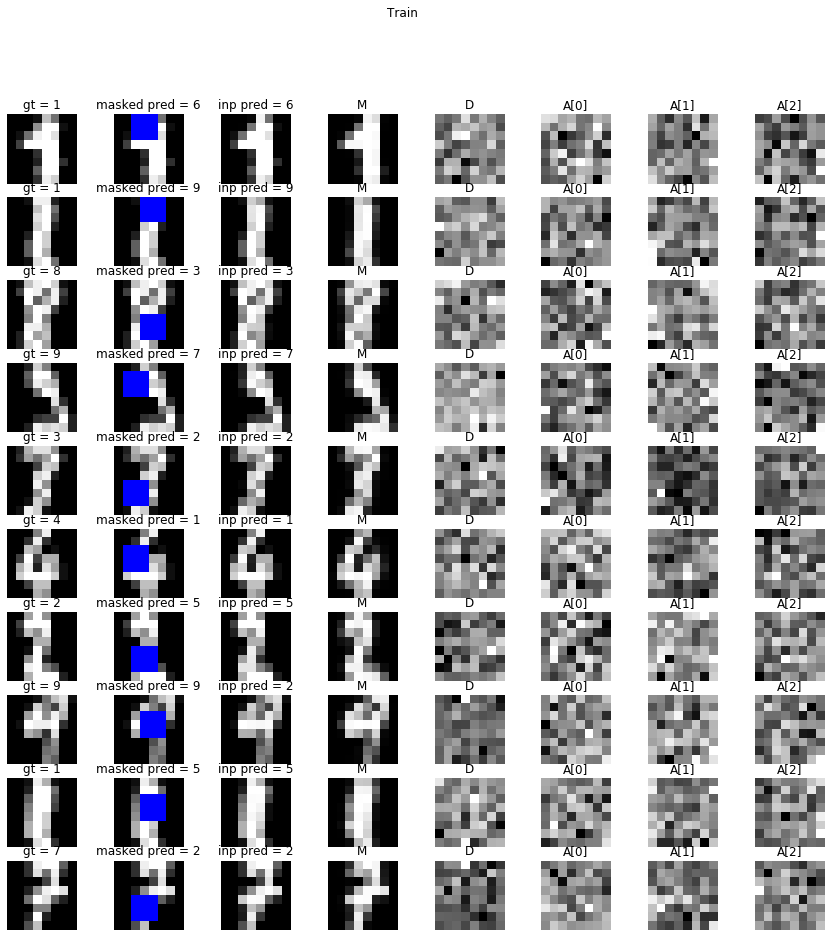

In [54]:
X_train_masked = X_train * J_train

P_train, M_train, A_train, D_train = inpainter(torch.Tensor(X_train_masked), torch.Tensor(J_train))
y_train_masked_pred = classifier.predict(X_train_masked)


X_train_inpainted = X_train_masked.copy()
X_train_inpainted[J_train == 0] = M_train.detach().cpu().numpy()[:, 0][J_train == 0]

# print("X_test[0]", X_test[0]), 
# print("X_test_masked[0]", X_test_masked[0]) 
# print("M_test.detach().numpy()[0, 0]", M_test.detach().cpu().numpy()[0, 0]) 
# print("X_test_inpainted[0]", X_test_inpainted[0])
y_train_inp_pred = classifier.predict(X_train_inpainted)

fig, axes = plt.subplots(10, 5 + A_train.shape[2], figsize=(15, 15))
for i in range(10):
    
    ax = axes[i, 0]
    ax.set_title(f"gt = {y_train[i]}")
    ax.imshow(X_train[i].reshape(8,8), cmap="gray")
    ax.axis("off")
    
    axes[i,1].set_title(f"masked pred = {y_test_masked_pred[i]}")
    vis_digit_mask(X_train[i], J_train[i], ax=axes[i, 1])
    
    ax = axes[i, 2]
    ax.set_title(f"inp pred = {y_test_inp_pred[i]}")
    ax.imshow(X_train_inpainted[i].reshape(8,8), cmap="gray")
    ax.axis("off")
#     vis_digit_mask(X_train[i], J_train[i],ax)
    
    ax = axes[i, 3]
    ax.set_title(f"M")
    ax.imshow(M_train[i, 0].reshape(8,8).detach().numpy(), cmap="gray")
    ax.axis("off")
    
    ax = axes[i, 4]
    ax.set_title(f"D")
    ax.imshow(D_train[i, 0].reshape(8,8).detach().numpy(), cmap="gray")
    ax.axis("off")
    
    for j in range(A_test.shape[2]):
        ax = axes[i, 5 + j]
        ax.set_title(f"A[{j}]")
        ax.imshow(A_train[i, 0, j].reshape(8,8).detach().numpy(), cmap="gray")
        ax.axis("off")
plt.suptitle("Train")
plt.show()